# A Pseudoproxy Experiment with GraphEM and pseudoPAGES2k

**Expected time to run through: TBD mins**

This tutorial demonstrates how to get a reconstruction using GraphEM, leveraging a simple pseudoproxy dataset generated from iCESM gridded, with the realistic spatial availability but full temporal availablity of the PAGES 2k version 2 dataset.
The pseudoproxies are generated based on the original iCESM simulated surface temperature (`tas`) plus white noise with `SNR=10`. While with LMR it is advantageous to have many redundant proxies (as long as they are unbiased, which is the case here), with GraphEM this can lead to some counter-intuitive difficulties, which we explain below.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt

## Data Preparation

(<Figure size 720x720 with 1 Axes>, {'map': <GeoAxesSubplot:>})

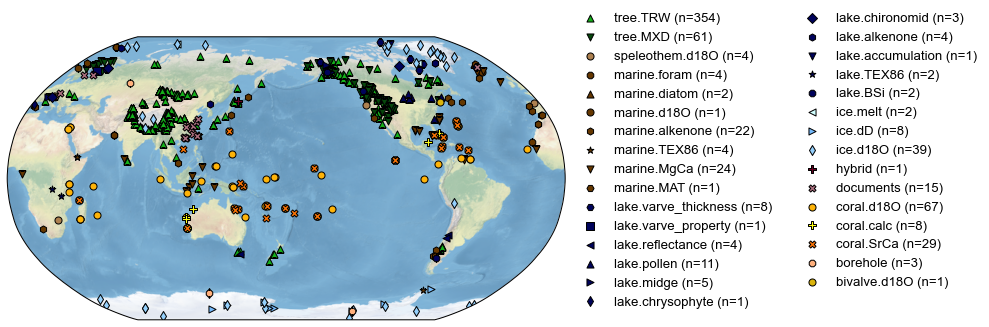

In [2]:
# load a proxy database
job = cfr.ReconJob()
job.proxydb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.tpn_SNR10.pkl')
job.proxydb.plot()

In [3]:
# filter the database
#job.proxydb = job.proxydb.filter(by='loc-square', keys=(-30, 30, 30, 250))
#fig, ax = job.proxydb.plot()

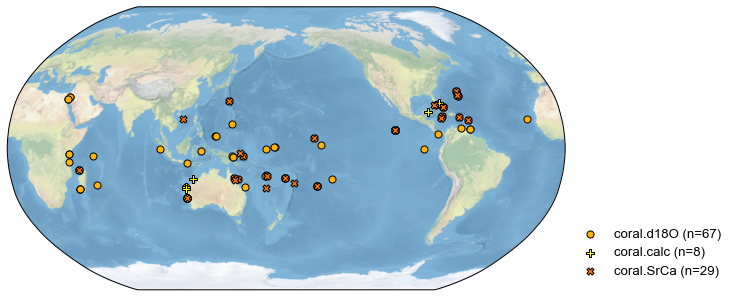

In [4]:
# filter the database
job.proxydb = job.proxydb.filter(by='ptype', keys='coral')
fig, ax = job.proxydb.plot()

In [5]:
job.proxydb = job.proxydb.center([1951, 1980])

Centering each of the ProxyRecord: 100%|█████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 3652.23it/s]


In [73]:
job.proxydb.records.keys() 

dict_keys(['Ocn_065', 'Ocn_075', 'Ocn_078', 'Ocn_167', 'Ocn_091', 'Ocn_093', 'Ocn_096', 'Ocn_086', 'Ocn_101', 'Ocn_070', 'Ocn_076', 'Ocn_099', 'Ocn_144', 'Ocn_178', 'Ocn_158', 'Ocn_149', 'Ocn_150', 'Ocn_177', 'Ocn_080', 'Ocn_171', 'Ocn_108', 'Ocn_103', 'Ocn_068', 'Ocn_069', 'Ocn_145', 'Ocn_098', 'Ocn_151', 'Ocn_152', 'Ocn_115', 'Ocn_170', 'Ocn_180', 'Ocn_154', 'Ocn_155', 'Ocn_111', 'Ocn_112', 'Ocn_116', 'Ocn_130', 'Ocn_131', 'Ocn_147', 'Ocn_106', 'Ocn_174', 'Ocn_077', 'Ocn_083', 'Ocn_160', 'Ocn_172', 'Ocn_060', 'Ocn_122', 'Ocn_166', 'Ocn_123', 'Ocn_140', 'Ocn_141', 'Ocn_164', 'Ocn_165', 'Ocn_179', 'Ocn_082', 'Ocn_066', 'Ocn_067', 'Ocn_138', 'Ocn_168', 'Ocn_142', 'Ocn_143', 'Ocn_088', 'Ocn_129', 'Ocn_110', 'Ocn_084', 'Ocn_073', 'Ocn_114', 'Ocn_081', 'Ocn_175', 'Ocn_176', 'Ocn_120', 'Ocn_121', 'Ocn_127', 'Ocn_128', 'Ocn_074', 'Ocn_183', 'Ocn_173', 'Ocn_118', 'Ocn_139', 'Ocn_061', 'Ocn_062', 'Ocn_079', 'Ocn_095', 'Ocn_156', 'Ocn_104', 'Ocn_107', 'Ocn_157', 'Ocn_146', 'Ocn_181', 'Ocn_182',

850.0 2005.0
850.0 2005.0
850.0 2005.0


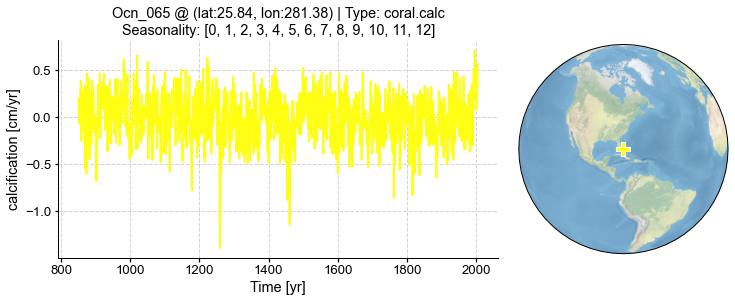

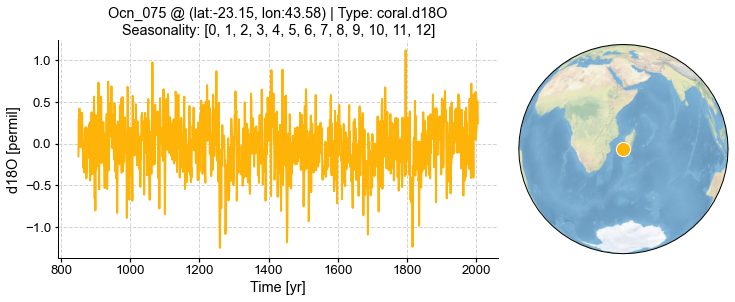

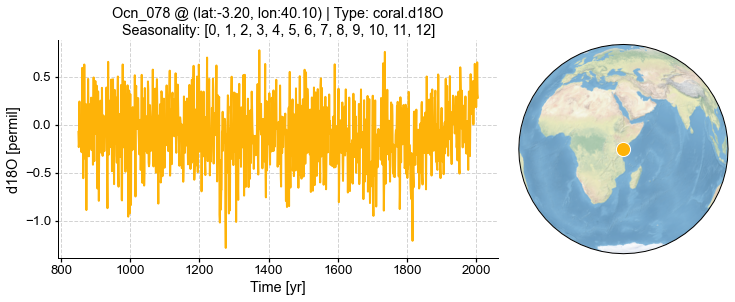

In [75]:
keys = ['Ocn_065', 'Ocn_075', 'Ocn_078'] # Question for Feng: how to automatically loop over proxydb items? 
for key in keys:
    rec = job.proxydb.records[key]
    rec.plot()

In [42]:
# load observations
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> obs variables ['tas'] loaded
>>> job.obs created


In [43]:
# regrid and crop obs to make the problem size smaller
job.regrid_clim(tag='obs', nlat=42, nlon=63, verbose=True)
#job.regrid_clim(tag='obs', nlat=32, nlon=50, verbose=True)
job.crop_clim(tag='obs', lat_min=-25, lat_max=25, lon_min=120, lon_max=280, verbose=True)

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["prior_lat_min"] = -25
>>> job.configs["prior_lat_max"] = 25
>>> job.configs["prior_lon_min"] = 120
>>> job.configs["prior_lon_max"] = 280
>>> Processing tas ...


>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> job.obs updated


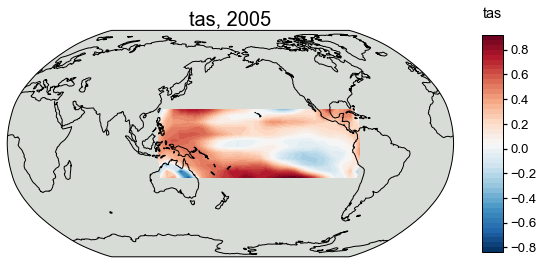

In [44]:
# annualize the observations
job.annualize_clim(tag='obs', verbose=True, months=list(range(1, 13)))
fig, ax = job.obs['tas'].plot(it=-1)

In [45]:
job.obs['tas'].da

<xarray.DataArray 'tas' (year: 1156, lat: 12, lon: 28)>
array([[[-1.43779302, -1.16293697, -1.01732908, ...,  0.39457998,
          0.52082612,  0.59373487],
        [-0.44181921, -0.51548275,  0.244261  , ...,  0.74474864,
          0.77145844,  0.68355714],
        [ 0.35079578,  0.32100882,  0.55368277, ...,  0.88217642,
          0.68757142,  0.31475473],
        ...,
        [ 0.72816369,  0.71887253,  0.54529944, ...,  0.20676015,
          0.30845679,  0.2907033 ],
        [ 1.10758701,  0.98782858,  1.00810014, ...,  0.09055938,
          0.18384386,  0.24694595],
        [ 1.31631178,  1.20505177,  1.04198581, ...,  0.14300547,
          0.29674634,  0.27620213]],

       [[-0.70474708, -0.01598469,  0.13178037, ..., -0.16622394,
         -0.03184134, -0.0226782 ],
        [-0.47576783, -0.55773132, -0.46185074, ..., -0.03219556,
          0.01012642,  0.01045555],
        [ 0.10615215, -0.04668079, -0.21236786, ...,  0.06428793,
         -0.00198371, -0.03837104],
...
        [ 0.25181528,  0.44903654,  0.61978375, ...,  0.31308888,
          0.36723991,  0.52567691],
        [ 0.04978446,  0.04787485,  0.22568625, ...,  0.45198041,
          0.4664865 ,  0.49749394],
        [ 0.10458478, -0.10605026, -0.21279729, ...,  0.54345012,
          0.54446683,  0.52080011]],

       [[ 0.0498074 ,  0.27873075,  0.39957376, ..., -0.03960866,
         -0.05272122,  0.16753688],
        [-0.37810031,  0.30122609, -0.0628949 , ..., -0.11026585,
          0.06519481,  0.26313251],
        [ 0.08783609, -0.448483  , -0.12010821, ..., -0.0352111 ,
          0.10163381,  0.12676614],
        ...,
        [ 0.09630422,  0.35422082,  0.39387372, ...,  0.24968949,
          0.3645677 ,  0.26936438],
        [-0.06625534,  0.26004941,  0.47504105, ...,  0.32676493,
          0.46907017,  0.4533393 ],
        [-0.19586628,  0.12946299,  0.54914526, ...,  0.38060853,
          0.41296104,  0.51346773]]])
Coordinates:
  * year     (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
  * lon      (lon) float64 121.9 127.7 133.5 139.4 ... 261.3 267.1 272.9 278.7
  * lat      (lat) float64 -24.15 -19.76 -15.37 -10.98 ... 15.37 19.76 24.15

The method `prep_graphem()` helps weave everything into an object that the code can work with:

In [46]:
job.prep_graphem(
    recon_period=(1001, 2000),
    calib_period=(1850, 2000),
    verbose=True)

>>> job.recon_time created
>>> job.calib_time created
>>> job.calib_idx created
>>> job.temp created
>>> job.df_proxy created
>>> job.proxy created
>>> job.lonlat created


In [47]:
job.temp

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.70970161, 0.73450522, 0.30319882, ..., 0.34267614, 0.25509715,
        0.39273508],
       [0.57543254, 0.4847614 , 0.17716476, ..., 0.26505406, 0.25998264,
        0.37178005],
       [0.66133266, 0.97367383, 1.02246066, ..., 0.0466115 , 0.12031657,
        0.13679344]])

In [48]:
job.df_proxy

,Ocn_065,Ocn_075,Ocn_078,Ocn_167,Ocn_091,Ocn_093,Ocn_096,Ocn_086,Ocn_101,Ocn_070,...,Ocn_090,Ocn_119,Ocn_109,Ocn_097,Ocn_159,Ocn_087,Ocn_153,Ocn_169,Ocn_071,Ocn_072
1001.0,-0.137829,-0.205720,-0.647684,0.898822,-0.356257,-0.356257,0.425059,0.029546,-0.185165,-0.362198,...,-0.288019,-0.756506,-0.157369,-0.288019,-0.756506,-0.636890,-0.348730,-0.332147,-0.395720,-0.395720
1002.0,-0.376911,-0.380234,-0.836313,-0.215733,-0.488090,-0.488090,-0.455390,-0.366285,-0.751944,-0.417541,...,-0.892699,-0.212252,-0.503061,-0.892699,-0.212252,0.603636,-0.293169,-0.315477,-0.374382,-0.374382
1003.0,-0.074143,0.186897,0.083945,0.439043,-0.002832,-0.002832,-0.364133,-0.243331,-0.202119,-0.170308,...,-0.144198,-0.067308,-0.028223,-0.144198,-0.067308,-0.067106,0.440870,0.147798,0.223871,0.223871
1004.0,-0.396937,-0.023028,-0.026614,0.381423,0.060887,0.060887,0.255347,0.171702,0.404180,-0.329291,...,0.120833,-0.416455,0.350750,0.120833,-0.416455,-0.355235,-0.066871,-0.152709,-0.159114,-0.159114
1005.0,0.189849,-0.203502,-0.267335,0.186128,0.080553,0.080553,-0.190592,-0.152617,-0.247644,0.045527,...,-0.126214,-0.461959,0.005048,-0.126214,-0.461959,-0.654685,-0.108365,-0.336745,-0.441364,-0.441364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996.0,0.711621,0.291426,0.632199,0.143895,-0.054895,-0.054895,-0.664192,-0.030944,0.308333,0.722785,...,0.268700,0.497055,-0.424533,0.268700,0.497055,0.247637,0.888607,0.429088,0.342945,0.342945
1997.0,0.203162,0.197638,0.397577,-0.058669,0.434051,0.434051,0.580503,0.313273,0.388179,0.188451,...,0.511296,0.012817,0.505579,0.511296,0.012817,-0.547594,0.074774,-0.003518,-0.219055,-0.219055
1998.0,0.449263,0.620285,0.331003,-0.710221,0.669881,0.669881,0.355502,0.194011,0.340377,0.401034,...,0.358588,0.680764,0.715996,0.358588,0.680764,1.208492,0.525448,0.066342,0.015942,0.015942
1999.0,0.491018,0.049518,0.595795,0.114631,0.376434,0.376434,-0.012054,0.322021,0.886320,0.350865,...,0.389719,0.386616,0.212224,0.389719,0.386616,0.189435,0.587975,0.429542,0.454576,0.454576


In [49]:
print(np.shape(job.temp))
print(np.shape(job.proxy))
print(np.shape(job.lonlat))

(1000, 336)
(1000, 104)
(440, 2)


## Graph estimation

In GraphEM, the selection of the covariance model used for inferring missing values is based on a [graph](http://ir.hit.edu.cn/~jguo/docs/notes/report-in-princeton-research.pdf). 
Two types of graphs are supported:
1. Neighborhood graphs
2. Empirical graphs (graphical lasso)


## 1. Neighborhood graph as initial guess

In [50]:
g0 = cfr.graphem.Graph(job.lonlat, job.temp, job.proxy)

Let us define a neighborhood graph by including only points within a cutoff_radius $R$ of each grid point or proxy locale. The location takes a bit of time the first time around as the matrix of mutual great- circle distances needs to be computed: 

In [51]:
g0.neigh_adj(cutoff_radius=1500)

Next we plot the temperature neighbors of a particular proxy to show what happened:

(<Figure size 288x288 with 1 Axes>,
 <GeoAxesSubplot:title={'center':'Neighbors of the target proxy (r=1500 km)'}>)

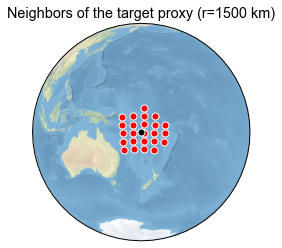

In [52]:
i = 20  # index of proxy
g0.plot_neighbors(i)

This, however, does not tell us the degree to which this proxy correlates to temperature at nerby grid points over the instrumental era. To do that, we use:

(<Figure size 360x360 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Neighbors of the target proxy (r=1500 km)'}>)

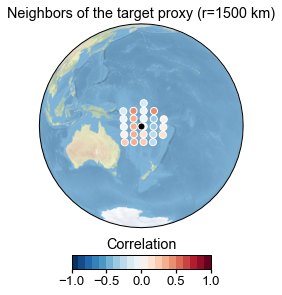

In [53]:
g0.plot_neighbors_corr(i)

This can be instructive for small proxy networks, or for debugging purposes. For a bird's eye view of the graph, we instead plot the adjacency matrix itself (dots indicate neighbors):

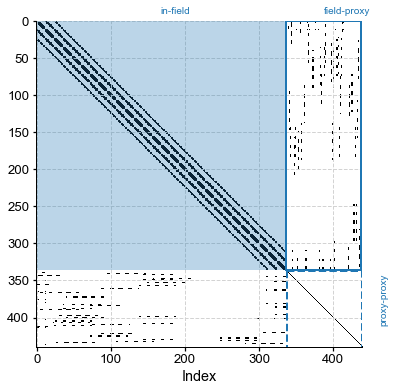

In [55]:
g0.adj_plot()

By construction, proxies are assumed conditionally independent of each other, so the proxy-proxy part of the adjacency matrix is diagonal. The climate-climate is block-diagonal, reflecting the fact that nearby indices tend to reflect nearby gridpoints, and nearby gridpoints generally have similar climates*.  There are discontinuities that happen when cycling through longitudes (0 --> 360 back to 0), which show up as abrupt breaks in the graph. The climate-proxy part is less regular, reflecting the fact that proxy locations are not uniformly spaced (unlike the grid points of the climate field). Notice how the overall matrix is very __sparse__: only a handful of of entries are non-zero (white is the main color on this plot). To be more precise, the `sparsity` property quantifies the fraction of non-zero entries:

In [56]:
g0.sparsity

[0.05653873489694385, 0.03345352564102564, 0.0]

We see that only a few % of the graph of the climate field and of the climate-proxy graph, have non-zero entries (the diagonal is excluded from this calculation, because a random variable is always conditionally dependent on itself; therefore, the proxy-proxy part of the graph has a sparsity of 0). This graph has achieved what we want: reducing the number of parameters to be estimated while computing the covariance matrix, which otherwise would be ill-conditioned. Will this suffice to yield a good estimate? Or have we thrown out the rubber duckies with the bath water and jettisoned too much information? The control knob here is the cutoff-radius. Unfortunately, there is no theoretical criterion on how to choose an appropriate one. At a minimum, it should be larger than the largest spacing between nearby grid points (which tends to at the equator). At most, it should be the scale of the planet. That leaves quite some room in between. We will first carry out a preliminary reconstruction, before refining the choice of cutoff-radius via a process called [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

## Preliminary reconstruction

In [38]:
job.run_graphem?

Signature: job.run_graphem(save_path, verbose=False, **fit_kws)
Docstring:
Run the GraphEM solver, essentially the :py:meth: `GraphEM.solver.GraphEM.fit` method

Note that the arguments for :py:meth: `GraphEM.solver.GraphEM.fit` can be appended in the
argument list of this function directly. For instance, to pass a pre-calculated graph, use
`estimate_graph=False` and `graph=g.adj`, where `g` is the :py:`Graph` object.

Args:
    save_path (str): the path to save the fitting result
    verbose (bool, optional): print verbose information. Defaults to False.
    fit_kws (dict): the arguments for :py:meth: `GraphEM.solver.GraphEM.fit`

See also:
    cfr.graphem.solver.GraphEM.fit : fitting the GraphEM method
File:      ~/Documents/GitHub/cfr/cfr/reconjob.py
Type:      method


Using specified graph
Running GraphEM:

Iter     dXmis     rdXmis



/Users/julieneg/Documents/GitHub/cfr/cfr/graphem/solver.py:476: LinAlgWarning: Ill-conditioned matrix (rcond=9.98181e-35): result may not be accurate.
  beta_star = linalg.solve(W11_star,s12_star, assume_a='sym')
/Users/julieneg/Documents/GitHub/cfr/cfr/graphem/solver.py:476: LinAlgWarning: Ill-conditioned matrix (rcond=1.37597e-18): result may not be accurate.
  beta_star = linalg.solve(W11_star,s12_star, assume_a='sym')
/Users/julieneg/Documents/GitHub/cfr/cfr/graphem/solver.py:476: LinAlgWarning: Ill-conditioned matrix (rcond=1.07701e-50): result may not be accurate.
  beta_star = linalg.solve(W11_star,s12_star, assume_a='sym')


LinAlgError: Matrix is singular.

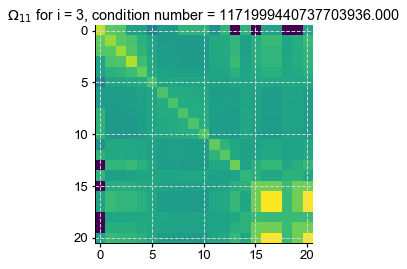

In [111]:
%%time
# need to remove G.pkl if the previous run is problematic
save_path = './results/graphem-ppe-pages2k/G.pkl'
job.run_graphem(save_path=save_path, verbose=True, estimate_graph=False, graph=g0.adj)

What an error message ! The algorithm wasn't able to run a single iteration. Indeed, it failed at the first calculation. Is it broken? 

# Bug Hunting

The key to this error message is to realize that a subset of a correlation matrix called W11_star is singular; this happens most often because predictors are colinear (i.e. columns of the data matrix are the same, so the information is redundant, which chokes up this algorithm). This situation is an artifact of this pseudoproxy case with dream-like SNR, and is extremely unlikely to arise with real proxies. Nevertheless, we need to deal with it numerically to ensure a solution. 

Text(0.5, 0, '$r$')

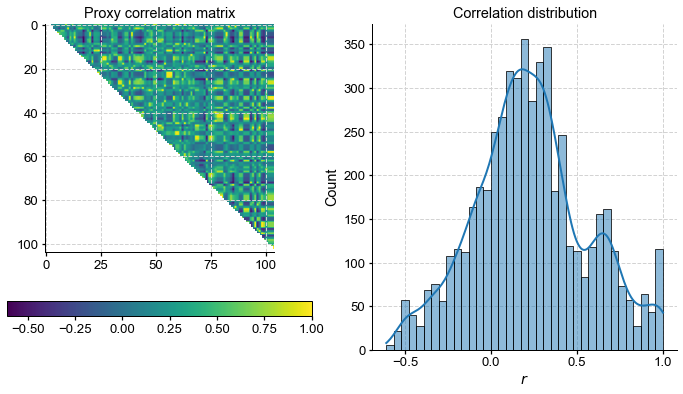

In [112]:
import seaborn as sns

R = np.triu(np.corrcoef(job.proxy.T),k=1) # exclude diagonal and lower triangle (matrix is symmatric --> double counting)
R[R==0]=np.nan

    
fig, ax = plt.subplots(1,2,figsize=(12,6))
mappable= ax[0].imshow(R)
plt.colorbar(mappable,ax=ax[0],orientation = 'horizontal')
ax[0].set_title('Proxy correlation matrix')

sns.histplot(R.flatten(),ax=ax[1],kde=True)
ax[1].set_title('Correlation distribution')
ax[1].set_xlabel(r'$r$')

In [137]:
di,dj=np.where(R==1)

array([  1,   1,   2,   4,   4,   4,   5,   5,   6,   6,   6,  12,  13,
        13,  15,  18,  19,  21,  22,  22,  23,  25,  26,  28,  29,  29,
        30,  31,  33,  36,  39,  40,  43,  43,  43,  43,  43,  45,  47,
        47,  49,  51,  51,  52,  55,  58,  59,  68,  70,  72,  78,  78,
        79,  83,  88,  90,  90,  90,  90,  91,  91,  91,  92,  92,  94,
        95, 102])

In [145]:
npairs = np.sum(np.logical_not(np.isnan(R)))
print("There are {:3.2f} % duplicate pairs among this proxy set".format(len(di)/npairs*100))

There are 1.25 % duplicate pairs among this proxy set


Indeed we see that about 1% of pairs have duplicate values. They need to be removed if we are to conduct a sucessful reconstruction. For this, we can rerun `prep_graphem` by setting the flag `remove_duplicates = True`: 